# Image compression using autoencoders: a deep learning task

Time : 8h

# Goal of this lab

* Get to know deep learning and PyTorch framework
* Learn how to compress images using autoencoders
* Understand the differences between JPEG compression and deep learning-based compression
* Know how to read and use code given by someone else


# Outline
* 0 - Introduction and documents reading
* 1 - Discovering a dataset
* 2 - Creating a model
* 3 - Training the model
* 4 - Testing the model
* 5 - Reporting the findings

# Disclaimer

We will refer to :
- AutoEncoder as AE
- Multi Layer Perceptron as MLP

Please make sure that your environment has a GPU. For that, go to: 
* Execution
* Modifier le type d'execution
* Accelerateur matériel: GPU

# 0 - Introduction

We have seen JPEG compression, a general algorithm that can compress any image. Let's first see your understanding of the JPEG algorithm :
* What are the component in the encoding part of the algorithm ?
* What are the component in the decoding part of the algorithm ?
* Is the down-sampling phase of JPEG linear ? (i.e : in a y = ax+b form)
* Is it a lossless compression algorithm ?

## a- Your mission: AI for the Win

Hi there, we are a Big Company and we need your help as a data scientist. We have some images to compress. We tried the JPEG algorithm but we also want to try some modern methods based on deep learning (DL). 


In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transform

## b - Reading the documents 

**Very important: take 20-25 minutes to read the following documentation to understand the basic.**



### i - What is deep learning ?

Deep Learning is a branch of AI where you **teach a Model** a certain **task** using a **Dataset**. The model or a neural network is built by multiple consecutive **layers** of neuron-like units, remotely based on neurons in the human brain. Typically, many consecutive layers are used, that is why it is referred to as deep learning. In those layers, each neuron has several **parameters** (**weights**) that are updated during **training** by minimizing a **loss** (error) function, using **Stochastic Gradient Descent**. Besides the model parameters, to be found using a dataset, there are also **hyperparameters** that you have to tune by yourself, for example, how many layers used in your model, how many neurons per layer,.... The Model infers a prediction from an **input**. In fact, a Deep Neural Network can be seen as a complex function ${f}$ that maps the input data to a learned space from the Dataset. 

Note the bold words. These are the important things you need to understand about Deep Learning. 

### ii- Generalities on AutoEncoder

<img src = "https://blog.keras.io/img/ae/autoencoder_schema.jpg">

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. In almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. 

2) Autoencoders are lossy.

3) Autoencoders are learned automatically from data examples.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation. In fact, we can look at the model as a big function :

* Encoder : This part compresses the input image to a compressed version of it, where $f(x)= z$, where $x$ is the input image, and $z$ the compressed representation of it.
* Decoder : This part of the model decompresses the compressed representation $z$ to the decompressed image $\tilde{x}$, in other terms we have a function $g$ where, $\tilde{x} = g(z)$
* AutoEncoder : by stacking the Encoder and the Decoder, and as we want $\tilde{x} = x$ (a.k.a the reconstructed image as similar as the input image), we can rewrite the AE as $\tilde{x} = g(z) = g\circ f(x)=  x$ where $g= f^{-1}$



### iii - Layers

A Layer is an important part of a model. In fact, it is the key element of a DL model. A Layer is a structure that takes information from one layer to pass them to the next layer. In a DL network, each layer extracts some kinds of features. 

### iv -  Activation functions

An (non-linear) activation function decides the output of a neuron. It is the equivalent of the excitation threshold for which a neuron reacts or not. **Hints: as activation function in hidden layers, ReLU is often used while sigmoid is not used, due to their properties, notably the calcul complexity of their gradient used for the backpropagation.**

<img src = "https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png" height = 200>

# 1- Exploring the data

## Dataset

<img src="https://labelyourdata.com/img/article-illustrations/splitting_data.png" height=200>


When training  a DL model, we use a Dataset. The model uses the data to learn something for a task. We usually divide the data into Training, Validation, Test sets.
- Training set is used to train the Model (i.e., to find the parameters of Model).
- Validation set is used to watch the Model's training (to verify whether the training procedure goes well).
- Test set is used to evaluate the performance of the Model (in our case, to measure if the model compresses and decompresses well new images).

<img src="https://i.imgflip.com/653bu2.jpg" height=400>

**In our case of AE, we do not need the label of image. Our method is an unsupervised algorithm.**

### a - The first one : the training set

- What is the size of the training dataset?
- What are the elements available in one piece of data? (image, label)
- What is the shape of one piece of data?
- What is the type of one piece of data?
- Plot few elements of the dataset using matplotlib (plt since matplotlib was imported as plt).

torch.Size([1, 28, 28])


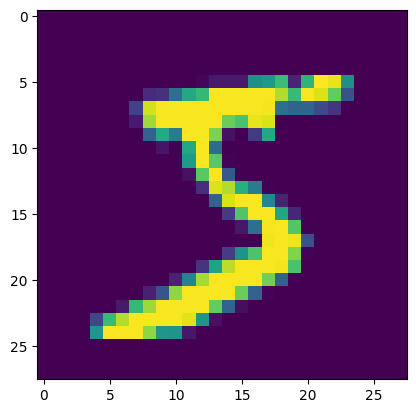

In [117]:
# Load MNIST Train dataset from TorchVision

dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())

# TODO: What's the size of the Dataset ?
#60,000 training images.
# Hint: run the code below, show the value of size_of_dataset
# TODO: Retrieve one element of the Dataset ? What is the shape of one piece of Data ? 
# No code here, just answer the question

size_of_dataset =  len(dataset)
data = dataset[0]
print(data[0].shape) # Question : Why is there [0] ?
# end TODO

# Plot the retrieved Data
plt.imshow(data[0].permute(1, 2, 0)[...,0])
# end TODO


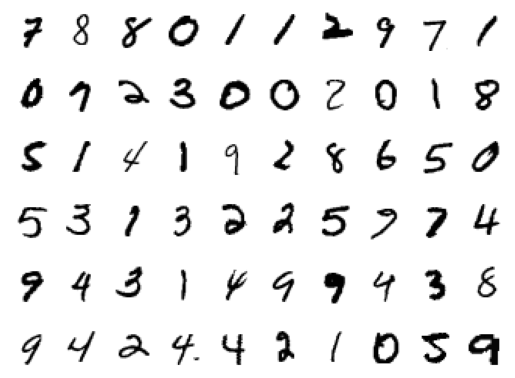

In [118]:
# Have a look at these codes, try to understand something
# Run them to see more about the dataset

loader_example = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
dataiter = iter(loader_example) # creating a iterator
data, labels = next(dataiter)
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(data[index].numpy().squeeze(), cmap='gray_r')

### b - The second one: the test dataset

As you can see in the above code, there's a "train" attribute of the MNIST class. When it is set to True, you are loading the training dataset. Therefore, in the following code, change it to false to load the test dataset.

In [4]:
# TODO : Load the test dataset. Inspire yourself from the minst_train dataset loading

mnist_test = MNIST('', train=False, download=True, transform=transforms.ToTensor())


1
torch.Size([1, 28, 28])


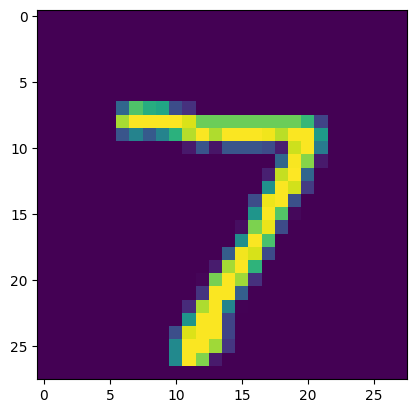

In [5]:
# TODO: What's the size of the Dataset ?
# TODO: Retrieve one element of the Dataset ? What is the shape of one piece of Data ? 
# TODO: Plot the retrieved Data




size_of_dataset =  len(mnist_test)
data = mnist_test[0]
print(data[0].shape[0]) 
print(data[0].size())
# Plot the retrieved Data
plt.imshow(data[0].permute(1, 2, 0)[...,0])

### c - The third one: creating the Validation dataset

Besides the training and testing sets, we would have a validation set. The validation set allows us to follow the training of model or in another words, to verify whether the training procedure goes well. 

In the next codes,
- What do 55000 and 5000 mean ?
55000 images for the training set and 5000 for the validation set 
- Determine the split value of the training set to create the validation dataset

In [115]:
# Questions : what do 55000 and 5000 mean ? Hint: look at the Dataset length and determine the split value
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

### d - Creating the Dataloader

The dataset returns one element at a time. In DL, we like sending many items at the same time to the model. We form BATCH of Data using a DataLoader. Dataloader is iterable over the dataset. It means that the Dataloader will form BATCH of Data for you and fetch them.

- Create a DataLoader for your Training, Validation and Test dataset (do not change the third attribute)

More information on dataloader : https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [116]:
train_loader = DataLoader(mnist_train, batch_size=128, drop_last = True)
val_loader = DataLoader(mnist_val, batch_size=128, drop_last = True)
test_loader = DataLoader(mnist_test, batch_size=128, drop_last = True)

# 2 - Creating and training the model: AutoEncoder

We saw what the data was and created our datasets. We need now to fullfil our mission and we need a model.

<img src="https://i.imgflip.com/640uob.jpg" height=300>

We are going to explore the path of AutoEncoder! Let's write some readable codes. Our code must be modulable and easy to read. We should try two types of AutoEncoders :    
- MLP Style
- Conv Style


Use PyTorch and Create Modulable and Stackable Models that inherits from nn.Module.




## a - MLP Style : Exploring the Neurons

<img src='https://www.researchgate.net/publication/344394387/figure/fig1/AS:974657746399232@1609387923440/Figure-Computational-Schematics-of-the-MLP-and-the-autoencoder.png'>

We will first try a MLP AE.




#### Creating a Model in PyTorch

Creating a model in PyTorch is simple. A PyTorch is an object that inherits from nn.Module. The pseudo-code is the following :     

```
class Model(nn.Module):
  def __init__(self,...):
    """"
    Define the model. You can put the input size as a parameter if needed..
    """"
    super().__init__() # to init the main class
    self.layers = ... # defining the model : could be Conv2d, Linear, RNN, LSTM


  def forward(self,x):
    """
    The input x is forwarded through the neural net. 
    """
    output = self.layers(x)
    return output

  # Other methods go down
```

More informations : https://pytorch.org/docs/stable/nn.html


### i - Correcting the Mistakes

First, we will try a really simple model :
* an Input Dense layer
* a latent space
* an Output Dense layer


We have received some codes from the other members of the Deep Learning Engineering Team. There are lots of mistakes... Let's correct them.

In [8]:
# TODO: Correct the following class. 
# Hint: Look at the input, output size, the activations, how the data is forwarded ...
# Hint: for activations, look at their above hints
# We have in this lab a variable called 'compressed_space_size' but it is actually 'latent_space_size' that you will see later.

class AutoEncoder_MLP(nn.Module):
  def __init__(self, input_size, compressed_space_size):
    """
    The model is an Input Layer, a Hidden Layer and an Output layer 
    """
    super().__init__() 
    # TODO : Init the class attributes thanks to the arguments of the init methods
    self.input_size = input_size
    self.output_size = input_size
    self.compressed_space_size = compressed_space_size
    # TODO : Correct 3 mistakes from the model
    self.input = nn.Sequential(
            nn.Linear(self.input_size, self.compressed_space_size),
            torch.nn.ReLU()

        )
        
    self.output = nn.Sequential(
            nn.Linear(self.compressed_space_size, self.output_size), # Fix: swap input and output sizes
            nn.Sigmoid()
        )
    # end TODO: in total, there are 6 mistakes in all these 5 above lines

  def forward(self,x):
    """
    The input x is forwarded through the neural net. 
    """
    # TODO 
    compressed_image = self.input(x)
    decompressed_image = self.output(compressed_image)
    return decompressed_image

In [9]:
# TODO : Create an Instance of the Model by calling the Class with the correct values

model = AutoEncoder_MLP(input_size = 28*28,
                        compressed_space_size= 512)

# TODO : Print the model.
print(model)

AutoEncoder_MLP(
  (input): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


## b - Training

We can train the model. We have a Model and a Dataset. We need few more things..



### i - Loss function

The loss function must tell us how far our predictions are from the true labels. This could be done by comparing the distributions of two input data, or by directly comparing the data using some distance metrics.

We are reconstructing an image from its compressed version and we want  that the reconstructed image is similar to the original image. i.e $\tilde{x} = x$

<img src="https://i.imgflip.com/653jbl.jpg" height=400>



- How can you calculate the similarity between two vectors?
- What type(s) of loss function do you know that calculates the **distance** between two inputs?

More information: https://pytorch.org/docs/stable/nn.html#loss-functions

In [10]:
# TODO : Delete the uncorrect loss 
criterion = nn.MSELoss() 

""" 
Réponse : 
criterion = nn.MSELoss()
"""

' \nRéponse : \ncriterion = nn.MSELoss()\n'

### ii - An Optimizer

<img src="https://i.imgflip.com/640sfs.jpg" height= 400>

We need gradually update the weights of the model. In fact, we perform the **gradient descent** to recalculate the weights of each layer regarding the model's predictions. The optimizer will search for an Optimum. It needs a step to perform this research. This step is called the **learning rate**. The learning rate has an important effect on the learning phase (duration, convergence,...)

<img src=https://miro.medium.com/max/918/0*uIa_Dz3czXO5iWyI. height =300>

In this case, we will use Adam Optimizer (it is efficient). Don't hesitate to have a look at the other optimizers. 

More information: https://pytorch.org/docs/stable/optim.html

In [11]:
# TODO : define a small learning rate
learning_rate =  0.001
# TODO : load the Adam optimizer in the optimizer variable
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


### iii - Training

Please use GPU to accelerate this phase.

Now we have to create the training loop which consists of :
* Sending Data through the model to obtain Predictions
* Computing the Loss 
* Backwarding the Loss using Gradients 
* Logging the losses and accuracies (if exists)

The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

Gradient descent: think of it as you trying to answer an exercise : the first time you won't understand, the seconde time you'll suceed more, and so on...

In [12]:
# Pre Defined and Useful variables
device = 'cuda' if torch.cuda.is_available() else 'cpu' # To send to the gpu
mini_batches_print = 10 # To print every 10 mini batches

net = model.to(device)

# TODO: Define your number of epochs

num_epochs = 10

loss_train , loss_val = [], []
for epoch in range(num_epochs) : 
    running_loss_t,running_loss_v = 0.0, 0.0
    # TODO: Create your Training Loop
    for i, data in enumerate(train_loader, 0): 
        # TODO: load the data into two variables
        image, label = data[0],data[1]
        image = image.to(device)

        # TODO : reshape the input image using .view(...).to(device) so that it fits the input layers neuron numbers.
        # Don't forget the Batch Size, the 1st dimension must always be the Batch Size
        image_reshaped = image.view(-1, 28*28).to(device)
        #print(data[0].shape[0])
        optimizer.zero_grad()

        # TODO: send the reshaped image to the model
        outputs = net(image_reshaped)

        # TODO/Questions: Do we need to reshape the input image ? If yes, reshape the image
        outputs = outputs.view(-1, 1, 28, 28).to(device)
        # TODO : Compute the loss between outputs and image. Don't forget to send the image to the device
        loss = criterion(outputs,image)

        loss.backward()
        optimizer.step()
        running_loss_t += loss.item()
        if i == mini_batches_print :
          running_loss_t= running_loss_t/mini_batches_print  
          print('training loss is :',running_loss_t)
          loss_train.append(running_loss_t)  

    # TODO : Create your Validation Loop
    with torch.no_grad():
      for i, data in enumerate(val_loader, 0):    
        # TODO : Do the same as the Train loop but delete everything related to weight update (optimizer, loss backwards ...)
        image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
        outputs = net(image) # use net()
        outputs = outputs.view(outputs.size(0),-1).to(device) # use .view of outputs precedently found 
        loss = criterion(outputs,image ) # use criterion()
        

        running_loss_v += loss.item()
        if i == mini_batches_print :
            running_loss_v= running_loss_v/mini_batches_print 
            print('validation loss is :',running_loss_v)
            loss_val.append(running_loss_v)
      

training loss is : 0.1590608298778534
validation loss is : 0.010215252451598645
training loss is : 0.009800878632813693
validation loss is : 0.005001496197655797
training loss is : 0.004815003601834178
validation loss is : 0.0034273347817361357
training loss is : 0.0033138979692012072
validation loss is : 0.0026941354619339107
training loss is : 0.002582171536050737
validation loss is : 0.00231453093001619
training loss is : 0.002195135364308953
validation loss is : 0.0020386014832183717
training loss is : 0.001925547735299915
validation loss is : 0.0018456263467669487
training loss is : 0.0017318158177658915
validation loss is : 0.001700917584821582
training loss is : 0.0015806400682777167
validation loss is : 0.0015377455158159137
training loss is : 0.0014218570082448422
validation loss is : 0.0014545921934768558


### iv - Did it learn something ?

As you might see we've logged into two lists (train_loss, val_loss) of loss computed during training. Let's plot them (do not forget to put titles and axis)
- How can you tell that the training is over?

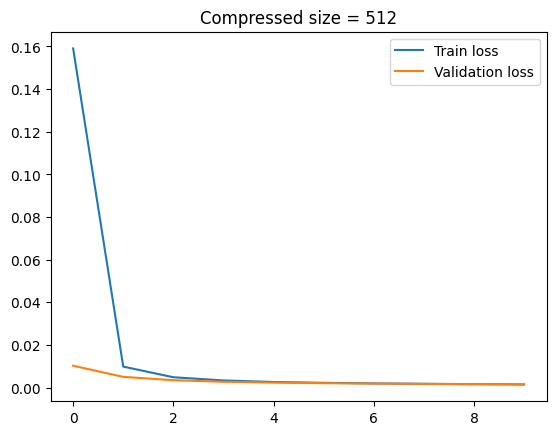

In [13]:
# TODO : plot the train and val loss on the same graph using matplotlib.pyplot.
# Always put legend on your graphs

# Plot the train and val loss on the same graph
plt.plot(loss_train, label='Train loss')
plt.plot(loss_val, label='Validation loss')
plt.title("Compressed size = 512")
plt.legend()
plt.show()



## c - Testing the compression

We already trained our model, let's test it on testing set. Here you go an email from the senior Data Scientist :


---

 🔊 🔊 🔊 **Message from the Senior Data Scientist** 🔊 🔊 🔊

Hi, this is C. the Senior Data Scientist

I heard that you've trained your model. Let's test it.
Take the test dataloader, iterate through it and send the test data to the model. We need to check how similar to the original image the decompressed image is..
Do not forget to delete all gradient calculation, it takes time and space for nothing. 


---





* Why must we not compute the gradients for the testing step?



torch.Size([128, 1, 28, 28])


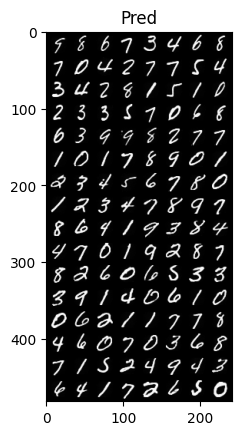

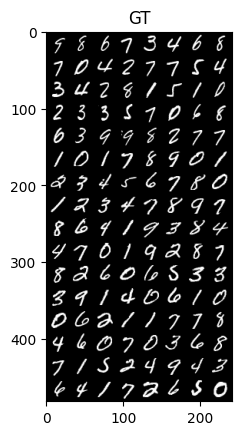

The difference between the Real Images and the Decompressed Images is:  tensor(0.0983, device='cuda:0')


In [14]:
def imshow(img,name= 'GT'):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(name)
    plt.show()

# TODO : form your testing loop. Is it different than the validation loop?
with torch.no_grad():
  losses = 0
  for i, data in enumerate(test_loader, 0):
    image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
    outputs = net(image) # use net()
    outputss = outputs.view(outputs.size(),-1).to(device)
    loss = criterion(outputss,image ) # use criterion()
    losses +=loss # accumulate 'loss' into 'losses'

# Plot the last batch
print(data[0].shape)
outputs = outputs.view(128, 1, 28, 28)
imshow(make_grid(outputs.detach().cpu()),'Pred')
imshow(make_grid(data[0]),'GT')

# TODO : Print the difference in decompression and write it somewhere
print('The difference between the Real Images and the Decompressed Images is: ',losses)

Error : 0.1711 for compressed size 128

Error : 1.9 for compressed size 16

Error : 0.2 for compressed size 1024

Error : 5.2 for compressed size 1

Error : 0.10 for compressed size 512

Let's see the effect of the compression: change the latent_size to different values. For example, try 512, 128, 16, 1.

<img src="https://i.imgflip.com/64elyi.jpg" height=200>

In [30]:
# TODO : Change your model, Test for differents size of Compressed Space Size. We advice you to try 1, 128, 512
model = AutoEncoder_MLP(28*28,512)

# TODO : Train it. Can we copy paste previous things ?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = model.to(device)
criterion = nn.MSELoss() 
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

# TODO : Train it. Can we copy paste previous things ?
for epoch in range(num_epochs) : 
    running_loss_t,running_loss_v = 0.0, 0.0
    # Train Loop
    for i, data in enumerate(train_loader, 0): 
      image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
      print(image.shape)
      optimizer.zero_grad()
      outputs = net(image)
      outputs = outputs.view(outputs.size(),-1).to(device)
      loss = criterion(outputs,image )
      loss.backward()
      optimizer.step()
      running_loss_t += loss.item()
      if i == 50:
        running_loss_t= running_loss_t/50
        print('training loss is :',loss)

    # Validation Loop
    with torch.no_grad():
      for i, data in enumerate(val_loader, 0):  
        image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
        outputs = net(image)
        outputs = outputs.view(outputs.size(),-1).to(device)
        loss = criterion(outputs,image )
        running_loss_v += loss.item()
        if i == 50:
            running_loss_v= running_loss_v/mini_batches_print 
            print('validation loss is :',running_loss_v)


# TODO : Test the Trained Model. Can we copy paste previous stuff ?

with torch.no_grad():
  losses = 0
  for i, data in enumerate(test_loader, 0):
    image, label = data[0].view(data[0].shape[0],-1).to(device), data[1]
    outputs = net(image) # use net()
    outputss = outputs.view(outputs.size(),-1).to(device)
    loss = criterion(outputss,image ) # use criterion()
    losses +=loss # accumulate 'loss' into 'losses'

# Plot the last batch
print(data[0].shape)
outputs = outputs.view(128, 1, 28, 28)
imshow(make_grid(outputs.detach().cpu()),'Pred')
imshow(make_grid(data[0]),'GT')

# TODO : Print the difference in decompression and write it somewhere
print('The difference between the Real Images and the Decompressed Images is: ',losses)


torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 784])
torch.Size(

KeyboardInterrupt: ignored

## d - Testing on other type of data

We can say that the model works pretty well on the test data. 

Let's test it on other kind of image.

* Write the code to test images taken from the internet.

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


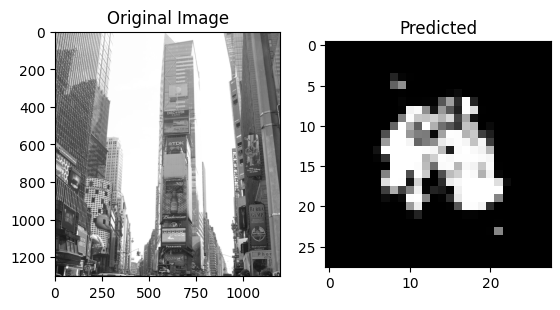

In [16]:
# TODO : Test some images from the internet to see the compression effect 
image_filename = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/New_York_City_Times_Square_03.jpg/1200px-New_York_City_Times_Square_03.jpg" # TODO: give a URL's image 
image_numpy = cv2.cvtColor(skimage.io.imread(image_filename ),cv2.COLOR_BGR2GRAY)
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize((28,28))])

# TODO : Transform the images and add a dimension for the batch size using unsqueeze
image = transform(image_numpy).unsqueeze(0)

# TODO : Send the model to the model and process the prediction. Don't forget 
# the resizes
model.eval()
with torch.no_grad():
    pred = model(image.view(image.shape[0],-1).to(device))
    pred = pred.view(pred.size(),-1).to(device)



# TODO : Plot dem results'. Don't forget to detach and send to the gpu the data
# using .detach().cpu()
pred = pred.view(1, 1, 28, 28)
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(image_numpy, cmap='gray')
axarr[0].set_title("Original Image")
axarr[1].imshow(pred.detach().cpu().numpy().squeeze(0).squeeze(0), cmap='gray')
axarr[1].set_title("Predicted")
plt.show()

* What can you say ?

# 3- Write your report

* Sum up all your understanding on this subject in two pages.

You should explain:
* The dataset you used for training,
* The tests you did,
* The models you tested,
* The results you had,
* The explanation of the results (why it works, why it doesn't),
* How can we compute the compression rate of the model? 
* Do we need to consider the model's size?

# 4 - Convolutional layer style : seeing a region

<img src="https://miro.medium.com/max/1838/1*LSYNW5m3TN7xRX61BZhoZA.png" height = 300>

---
 🔊 🔊 🔊 **Message from the senior data scientist** 🔊 🔊 🔊

Hello,

Good work! We need now to try another type of model.
Please consider Conv2d layers. 
Here you are some explanations: Convolutional Layers are filters that "scan" the input image in order to extract features. These filters extract features by looking at the region they're on.

I sent you some classes that you should use in your code. 

C.

<img src="https://i.imgflip.com/65b89l.jpg" height=300>

---



**Take 5 minutes to learn more about convolution with the following link: **

* https://ezyang.github.io/convolution-visualizer/

Questions:    
* What is the stride parameter?
* What is the padding parameter?
* What will change on the output when increasing the Kernel Size?

**Receptive field: are the pixels seen by filter kernel.**


## a - Model definition

Have a look at the model sent by the senior data scientist.

### i - Submodules

#### Conv Down

ConvDown is used to reduce the image size. A convolution on the input image is done using a kernel (the coefficients of kernel are weights to be found). In fact, it is used to extract interesting features of image. Our ConvDown Model will be composed of two layers:     
* Conv2d layer
* Non linearity (ReLU)

<img src="https://www.jeremyjordan.me/content/images/2017/07/no_padding_no_strides.gif">

In [17]:
class ConvDown(nn.Module):
    """
    This class takes as input the channels and returns a feature map 
    for the given output channel. 
    It indeed applies ReLU to it
    ConvDown stacks a Conv2d layer with an ReLU Activation 

    """
    def __init__(self, input_channel, output_channel, kernel_size = 3):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.model = nn.Sequential(nn.Conv2d(self.input_channel, self. output_channel, kernel_size =self.kernel_size ),
                                    nn.ReLU())
                                    
    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = self.model(x)
        return output

#### Conv Up

ConvUp is used to decompress the input image. In fact, it uses extracted features to reconstruct output feature map.

* Is it possible to increase output size map using Conv2d layers?

We can use also ConvTranpose2D layers, that use **transpose convolution** over an input image. These ConvTranspose layers learn to upsample the images.

<img src="https://miro.medium.com/max/1400/1*HnxnJDq-IgsSS0q3Lut4xA.gif" height=200>

In [18]:
class ConvUp(nn.Module):
    """
    ConvUp stacks a Conv2d layer with an Activation 
    If output is True : the Activation is Sigmoid
    If output is False : the Activation is ReLU
    """
    def __init__(self, input_channel, output_channel, kernel_size = 3 , output = True):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.output = output
        self.model = nn.Sequential(nn.ConvTranspose2d(self.input_channel, self.output_channel, kernel_size =self.kernel_size ),
                                    nn.ReLU()) if output is False else nn.Sequential(nn.ConvTranspose2d(self.input_channel, self. output_channel, kernel_size =self.kernel_size ),
                                    nn.Sigmoid())
        
    def forward(self,x):        
      # TODO :  Send the data through the model and return the output
      output = self.model(x)
      return output 

### ii - Modules : the wrappers

#### Encoder

The encoder stacks multiple ConvDown to compress and extract features.

<img src="https://i.imgflip.com/65bqe0.jpg" height=300>

In [19]:
class Encoder(nn.Module):
    """
    The encoder stacks multiple ConvDown to compress and extract features
    For the moment, we just keep one ConvDown layer

    """
    def __init__(self,input_channel, output_channel, kernel_size = 3):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.model = nn.Sequential( ConvDown(self.input_channel, self.output_channel,self.kernel_size))
                    
    def forward(self,x):
      # TODO :  Send the data through the model and return the output
      output = self.model(x)
      return output

#### Decoder

The decoder stacks multiple ConvUp to decompress and upsamples the input.

<img src="https://i.imgflip.com/65br5o.jpg" height=300>

In [20]:
# TODO : Find the error in the initialization and correct it
class Decoder(nn.Module):
    """
    The Decoder stacks multiple ConvUp to upsample and reconstruct from the input
    another feature map
    For the moment, we just keep one ConvDown layer
    NEEDS TO BE CORRECTED

    """
    def __init__(self,input_channel, output_channel, kernel_size = 3, output = True):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.output = output
        self.model = nn.Sequential(ConvUp(self.input_channel,self.output_channel, kernel_size=self.kernel_size, output=self.output))
        
    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = self.model(x)
        return output

### iii - The Conv AutoEncoder: final model 

We stack encoder and decoder in order to form the autoencoder.


In [21]:
class AutoEncoder_Conv(nn.Module):

    def __init__(self, input_size, latent_size, output=True):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.output = output

        # initialize encoder and decoder
        self.encoder = Encoder(self.input_size, self.latent_size)
        self.decoder = Decoder(self.latent_size, self.input_size)

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)

        # Pass the output of the encoder through the decoder
        decoded = self.decoder(encoded)

        return decoded
print(AutoEncoder_Conv(1,512))


AutoEncoder_Conv(
  (encoder): Encoder(
    (model): Sequential(
      (0): ConvDown(
        (model): Sequential(
          (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
        )
      )
    )
  )
  (decoder): Decoder(
    (model): Sequential(
      (0): ConvUp(
        (model): Sequential(
          (0): ConvTranspose2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
          (1): Sigmoid()
        )
      )
    )
  )
)


## b - Training and Testing

We can reuse the previously written code. However, we need to make some changes...

* What changes must we do ?


training loss is : tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(7.6914e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(6.0942e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(4.9891e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(4.1427e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(3.6217e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([128, 1, 28, 28])


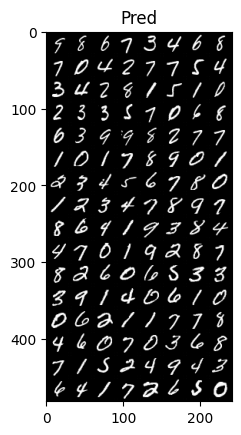

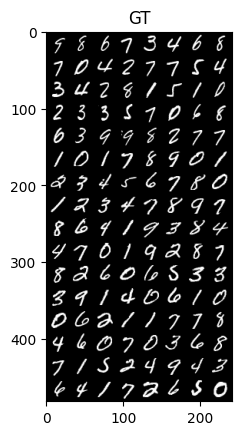

In [22]:
# TODO : Change your model 
model = AutoEncoder_Conv(1,512)

# TODO : Reload your HyperParameters

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = model.to(device)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

# TODO : Rewrite your Training  and Validation Loop
for epoch in range(num_epochs) : 
    running_loss_t,running_loss_v = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
      image, label = data[0].to(device), data[1]
      optimizer.zero_grad()
      outputs = net(image)
      outputs = outputs.view(outputs.size(),-1).to(device)
      loss = criterion(outputs,image )
      loss.backward()
      optimizer.step()
      running_loss_t += loss.item()
      if i == 50:
        running_loss_t= running_loss_t/50
        print('training loss is :',loss)

    with torch.no_grad():
      
      for i, data in enumerate(val_loader, 0):
        image, label = data[0].to(device), data[1]
        outputs = net(image)
        outputs = outputs.view(outputs.size(),-1).to(device)
        loss = criterion(outputs,image )
        running_loss_v += loss.item()
        if i == 50:
            running_loss_v= running_loss_v/mini_batches_print 
            print('validation loss is :',running_loss_v)




# TODO : Rewrite your Testing Loop
with torch.no_grad():
  running_loss = []
  for i, data in enumerate(test_loader, 0):  
    image, label = data[0].to(device), data[1]
    outputs = net(image)
    outputs = outputs.view(outputs.size(),-1).to(device)
    loss = criterion(outputs,image )
    running_loss.append(loss)


print(data[0].shape)
outputs = outputs.view(128, 1, 28, 28)
imshow(make_grid(outputs.detach().cpu()),'Pred')
imshow(make_grid(data[0]),'GT')

# TODO :  Plot the last batch and the Reconstruction Errors

Let's compare the results with different sizes (512, 128, 16, 1):
* What are the reconstruction values on the test set? 
* What is the training time?
* Which model would you advice? 

16: 0.0010

512: 4.1647e-05

## c - Deeper Models

All the models we've created are only composed of 3 layers (not really deep): 

      input layer => hidden layer => output layer

We can obviously stack more layers :    
* Modify the Convolutional Encoder and the Decoder so that the AE becomes :     
      input layer => hidden layer => hidden layer => hidden layer => output layer


We want the first and last hidden layer to have the same size

In [23]:
# TODO : Modify the Encoder and the Decoder by adding one additional hidden layer. The size of the additionnal hidden layer can be greater than the previous one
class Encoder(nn.Module):
    """
    Conv Encoder Class
    """
    def __init__(self,input_channel, output_channel, kernel_size = 3):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.model = nn.Sequential(ConvDown(self.input_channel, self.output_channel//2,self.kernel_size), 
                                   ConvDown(self.output_channel//2, self.output_channel,self.kernel_size))

    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = self.model(x)
        return output
 
class Decoder(nn.Module):
    """
    Conv Decoder Class
    be careful with the output attribute 
    """
    def __init__(self,input_channel, output_channel, kernel_size = 3, output = True):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.output = output
        self.model=  nn.Sequential(ConvUp(self.input_channel, self.input_channel//2,self.kernel_size),
                                   ConvUp(self.input_channel//2, self.output_channel,self.kernel_size))

                    
    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = self.model(x)
        return output



# TODO : Recreate the AutoEncoder using the Encoder and Decoder 
class AutoEncoder_Conv(nn.Module):

    def __init__(self,input_size,latent_size, output= True):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.output = output
        self.encoder = Encoder(self.input_size, self.latent_size)
        self.decoder = Decoder(self.latent_size, self.input_size)

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)

        # Pass the output of the encoder through the decoder
        decoded = self.decoder(encoded)

        return decoded



# TODO : Print the new model
print(AutoEncoder_Conv(1,128))


AutoEncoder_Conv(
  (encoder): Encoder(
    (model): Sequential(
      (0): ConvDown(
        (model): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
        )
      )
      (1): ConvDown(
        (model): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
        )
      )
    )
  )
  (decoder): Decoder(
    (model): Sequential(
      (0): ConvUp(
        (model): Sequential(
          (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
          (1): Sigmoid()
        )
      )
      (1): ConvUp(
        (model): Sequential(
          (0): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1))
          (1): Sigmoid()
        )
      )
    )
  )
)


Retrain your Model for a Compressed Space of :       
* 128 
* 64 

Compare the results

training loss is : tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(9.5153e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(6.5470e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(5.1460e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(3.4941e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(3.5321e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(6.7418e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
training loss is : tensor(2.6225e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.Size([128, 1, 28, 28])


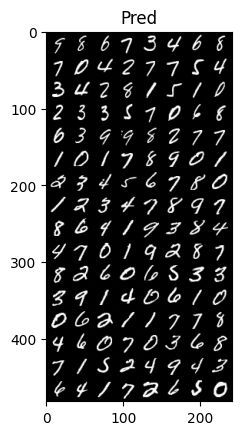

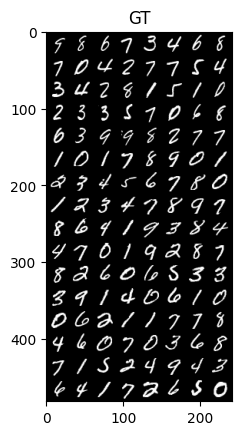

In [24]:
# TODO : Change your model 
model = AutoEncoder_Conv(1,128)

# TODO : Reload your HyperParameters


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = model.to(device)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

# TODO : Rewrite your Training  and Validation Loop
for epoch in range(num_epochs) : 
    running_loss_t,running_loss_v = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
      image, label = data[0].to(device), data[1]
      optimizer.zero_grad()
      outputs = net(image)
      outputs = outputs.view(outputs.size(),-1).to(device)
      loss = criterion(outputs,image )
      loss.backward()
      optimizer.step()
      running_loss_t += loss.item()
      if i == 50:
        running_loss_t= running_loss_t/50
        print('training loss is :',loss)

    with torch.no_grad():
      
      for i, data in enumerate(val_loader, 0):
        image, label = data[0].to(device), data[1]
        outputs = net(image)
        outputs = outputs.view(outputs.size(),-1).to(device)
        loss = criterion(outputs,image )
        running_loss_v += loss.item()
        if i == 50:
            running_loss_v= running_loss_v/mini_batches_print 
            print('validation loss is :',running_loss_v)




# TODO : Rewrite your Testing Loop
with torch.no_grad():
  running_loss = []
  for i, data in enumerate(test_loader, 0):  
    image, label = data[0].to(device), data[1]
    outputs = net(image)
    outputs = outputs.view(outputs.size(),-1).to(device)
    loss = criterion(outputs,image )
    running_loss.append(loss)


print(data[0].shape)
outputs = outputs.view(128, 1, 28, 28)
imshow(make_grid(outputs.detach().cpu()),'Pred')
imshow(make_grid(data[0]),'GT')


10 epoch, lr= 0.001, 128 : 2.9951e-05

https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

# 5 - Where's that noise?

AE can be used to denoise image. That means that if there are some noise in input image, the AE will be able to reconsctruct the image without noise.

<img src="https://miro.medium.com/max/1400/1*z7SUcHkWp7jT1D_SqvTvgA.png" height=300>


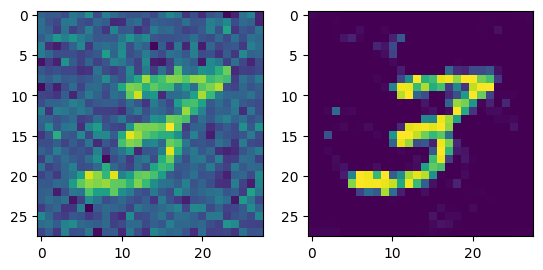

In [25]:
# TODO : Using torch.randn_like, create some noise and return a noisy input
def add_noise(inputs, noise_factor):
     # Generate noise
     noise = torch.randn_like(inputs)
     # Add noise to the input
     noisy_inputs = inputs + noise_factor * noise
     return noisy_inputs



# TODO : Pick an image from the test set and add noise to it 
test_image = data[0][69] # Pick an image from test dataset
test_image = add_noise(test_image,0.2) # Add noise

# TODO : Send the Image through your model and plot the original image and the infered image
denoised_image = model(test_image.to(device))
fig,axarr = plt.subplots(1, 2)
axarr[0].imshow(test_image.squeeze(0).squeeze(0).squeeze(0))
axarr[1].imshow(denoised_image.detach().cpu().squeeze(0).squeeze(0).squeeze(0))



* What can you tell ?
* Does it work with lots of noise ?

# 6 - Getting some colors (optional)

In this part, you will try all the things you've seen previously on a new Dataset. Instead of black and white images, here we have RGB colored images.

You must :    
* Check your Data
* Create the Dataloaders
* Create your Models
* Train your model for different parameters
* Test the model
* Provide some quantitative results on the behavior of your models.


## CIFAR10 : Colors and Classes


Do the similar steps as before. 

- What is the size of the train dataset?
- What are the elements available in one piece of data? (image,label)
- What is the shape of one piece of data?
- What is the type of one piece of data?
- Plot few elements of the dataset using Matplotlib.



100%|██████████| 170498071/170498071 [00:05<00:00, 29448298.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
3
torch.Size([3, 32, 32])
5
50000


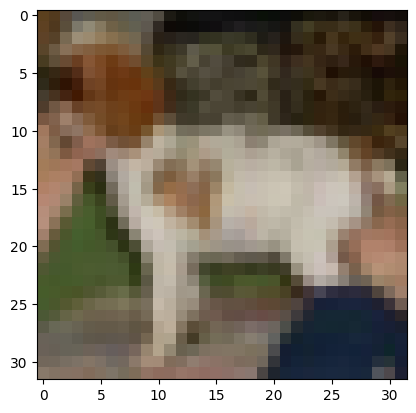

In [26]:
transform = transforms.Compose([transforms.ToTensor()])
dataset_train = CIFAR10(root='./data', train=True,download=True, transform=transform)
dataset_test =  CIFAR10(root='./data', train=False,download=True, transform=transform)
data = dataset_test[12]
print(data[0].shape[0]) 
print(data[0].size())
# Plot the retrieved Data
print(data[1])
print(len(dataset_train))
plt.imshow(data[0].permute(1, 2, 0))

In [84]:
# TODO : Do all the things related to MLP MODELs here
mnist_train, mnist_val = random_split(dataset_train, [46000, 4000])
train_loaderRGB = DataLoader(mnist_train, batch_size=64, drop_last = True)
val_loaderRGB = DataLoader(mnist_val, batch_size=64, drop_last = True)
test_loaderRGB = DataLoader(dataset_test, batch_size=64, drop_last = True)


training loss is : 0.05696063853800297
validation loss is : 0.09181764684617519
training loss is : 0.018324610758572817
validation loss is : 0.07007551956921816
training loss is : 0.014308735020458698
validation loss is : 0.06442781481891871
training loss is : 0.013116148505359889
validation loss is : 0.060585290938615796
training loss is : 0.012476224470883607
validation loss is : 0.05860867695882917
training loss is : 0.012087631840258836
validation loss is : 0.056882549449801444
training loss is : 0.01170026047155261
validation loss is : 0.05637758085504174
training loss is : 0.011596368011087179
validation loss is : 0.05609341664239764
training loss is : 0.011520868726074695
validation loss is : 0.0559210448525846
training loss is : 0.01149424521252513
validation loss is : 0.05587447518482804
torch.Size([64, 3, 32, 32])


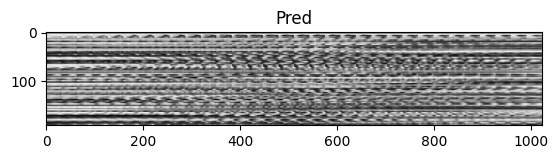

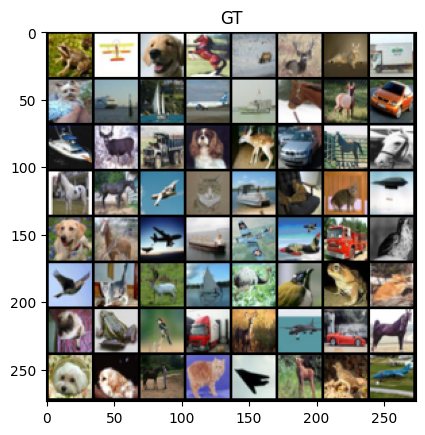

ValueError: ignored

In [87]:
# TODO : Do all the things related to TRAINING here
# TODO : Change your model, Test for differents size of Compressed Space Size. We advice you to try 1, 128, 512
model = AutoEncoder_MLP(32*32,128)

# TODO : Train it. Can we copy paste previous things ?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = model.to(device)
criterion = nn.MSELoss() 
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

# TODO : Train it. Can we copy paste previous things ?
for epoch in range(num_epochs) : 
    running_loss_t,running_loss_v = 0.0, 0.0
    # Train Loop
    for i, data in enumerate(train_loaderRGB, 0): 
      image, label = data[0].view(-1,32*32).to(device), data[1]
      
      optimizer.zero_grad()
      outputs = net(image)
      outputs = outputs.view(outputs.size(),-1).to(device)
      loss = criterion(outputs,image )
      loss.backward()
      optimizer.step()
      running_loss_t += loss.item()
      if i == 50:
        running_loss_t= running_loss_t/50
        print('training loss is :',running_loss_t)

    # Validation Loop
    with torch.no_grad():
      for i, data in enumerate(val_loaderRGB, 0):  
        image, label = data[0].view(-1,32*32).to(device), data[1]
        outputs = net(image)
        outputs = outputs.view(outputs.size(),-1).to(device)
        loss = criterion(outputs,image )
        running_loss_v += loss.item()
        if i == 50:
            running_loss_v= running_loss_v/mini_batches_print 
            print('validation loss is :',running_loss_v)


# TODO : Test the Trained Model. Can we copy paste previous stuff ?

with torch.no_grad():
  losses = 0
  for i, data in enumerate(test_loaderRGB, 0):
    image, label = data[0].view(-1,32*32).to(device), data[1]
    outputs = net(image) # use net()
    outputss = outputs.view(outputs.size(),-1).to(device)
    loss = criterion(outputss,image ) # use criterion()
    losses +=loss # accumulate 'loss' into 'losses'

# Plot the last batch
print(data[0].shape)
imshow(make_grid(outputs.detach().cpu()),'Pred')
imshow(make_grid(data[0]),'GT')
imshow(outputs[69].detach().cpu(),'Pred')
imshow(data[0][69],'GT')

# TODO : Print the difference in decompression and write it somewhere
print('The difference between the Real Images and the Decompressed Images is: ',losses)


torch.Size([64, 3, 32, 32])


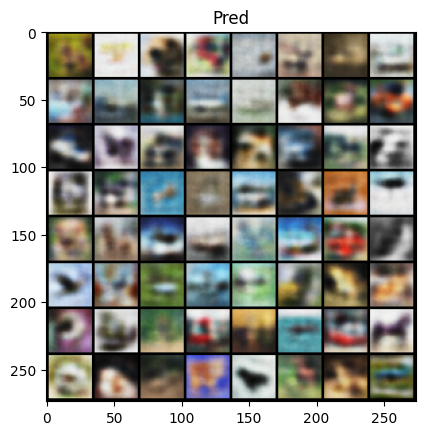

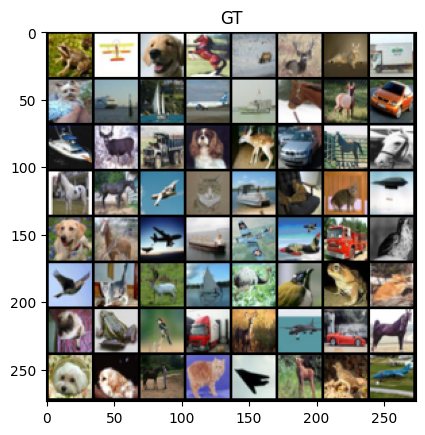

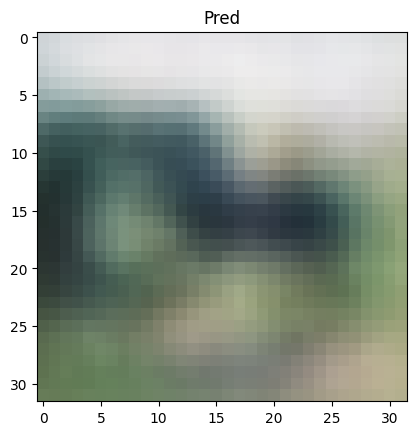

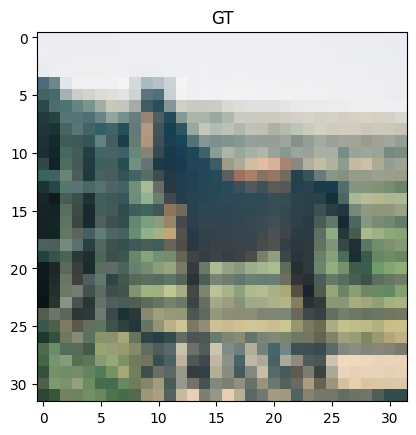

In [93]:

print(data[0].shape)
outputs = outputs.view(64, 3, 32, 32)
imshow(make_grid(outputs.detach().cpu()),'Pred')
imshow(make_grid(data[0]),'GT')
imshow(outputs[22].detach().cpu(),'Pred')
imshow(data[0][22],'GT')

Don't forget to write your results and explanation in your report

In [75]:
# TODO : Do all the things related to Conv MODELs here
class EncoderRGB(nn.Module):
    """
    Conv Encoder Class
    """
    def __init__(self,input_channel, output_channel, kernel_size = 3):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.model =  nn.Sequential(
                                    nn.Conv2d(input_channel, output_channel, 3, padding=1), # (32, 32)
                                    nn.ReLU(),
                                    nn.Conv2d(output_channel, output_channel, 3, padding=1), 
                                    nn.ReLU(),
                                    nn.Conv2d(output_channel, 2*output_channel, 3, padding=1, stride=2), # (16, 16)
                                    nn.ReLU(),
                                    nn.Conv2d(2*output_channel, 2*output_channel, 3, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(2*output_channel, 4*output_channel, 3, padding=1, stride=2), # (8, 8)
                                    nn.ReLU(),
                                    nn.Conv2d(4*output_channel, 4*output_channel, 3, padding=1),
                                    nn.ReLU(),
                                    nn.Flatten(),
                                    nn.Linear(4*output_channel*8*8, 200),
                                    nn.ReLU()
    )

    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        x = x.view(-1, 3, 32, 32)
        output = self.model(x)
        
        return output
 
class DecoderRGB(nn.Module):
    """
    Conv Decoder Class
    be careful with the output attribute 
    """
    def __init__(self,input_channel, output_channel, kernel_size = 3, output = True):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.output = output

        self.linear = nn.Sequential(
        nn.Linear(200, 4*output_channel*8*8),
        nn.ReLU()
        )
        
        self.model= nn.Sequential(
                                    nn.ConvTranspose2d(4*output_channel, 4*output_channel, 3, padding=1), # (8, 8)
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(4*output_channel, 2*output_channel, 3, padding=1, 
                                                      stride=2, output_padding=1), # (16, 16)
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(2*output_channel, 2*output_channel, 3, padding=1),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(2*output_channel, output_channel, 3, padding=1, 
                                                      stride=2, output_padding=1), # (32, 32)
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(output_channel, output_channel, 3, padding=1),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(output_channel, input_channel, 3, padding=1)
                                )

                    
    def forward(self,x):
        # TODO :  Send the data through the model and return the output
        output = self.linear(x)
        output = output.view(-1, 4*self.output_channel, 8, 8)
        output = self.model(output)
        return output



# TODO : Recreate the AutoEncoder using the Encoder and Decoder 
class AutoEncoder_ConvRGB(nn.Module):

    def __init__(self,input_size,latent_size, output= True):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.output = output
        self.encoder = EncoderRGB(self.input_size, self.latent_size)
        self.decoder = DecoderRGB(self.input_size,self.latent_size )

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        
        # Pass the output of the encoder through the decoder
        decoded = self.decoder(encoded)

        return decoded



# TODO : Print the new model
print(AutoEncoder_ConvRGB(3,16))

AutoEncoder_ConvRGB(
  (encoder): EncoderRGB(
    (model): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Flatten(start_dim=1, end_dim=-1)
      (13): Linear(in_features=4096, out_features=200, bias=True)
      (14): ReLU()
    )
  )
  (decoder): DecoderRGB(
    (linear): Sequential(
      (0): Linear(in_features=200, out_features=4096, bias=True)
      (1): ReLU()
    )
    (model): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3)

training loss is : tensor(0.0639, device='cuda:0', grad_fn=<MseLossBackward0>)
validation loss is : 0.08572274064645172
training loss is : tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)
validation loss is : 0.06256664376705885
training loss is : tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)
validation loss is : 0.04955188008025289
training loss is : tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)
validation loss is : 0.04529576143249869
training loss is : tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
validation loss is : 0.04284819015301764
training loss is : tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
validation loss is : 0.039353128988295794
training loss is : tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)
validation loss is : 0.038039550138637426
training loss is : tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)
validation loss is : 0.03573978976346552
training loss is : tensor(0.0078, devi

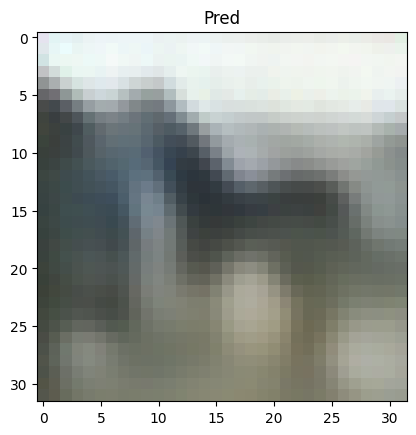

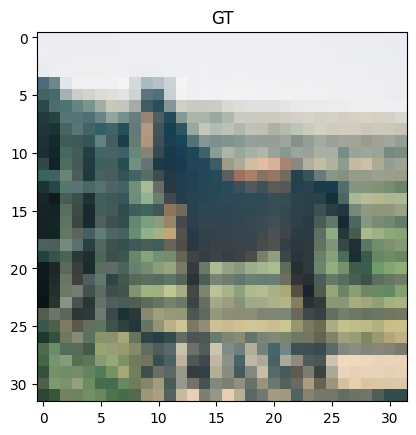

In [94]:
# TODO : Do all the things related to TRAINING here
# TODO : Change your model 
model = AutoEncoder_ConvRGB(3,16)

# TODO : Reload your HyperParameters


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = model.to(device)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

# TODO : Rewrite your Training  and Validation Loop
for epoch in range(num_epochs) : 
    running_loss_t,running_loss_v = 0.0, 0.0
    for i, data in enumerate(train_loaderRGB, 0):
      image, label = data[0].to(device), data[1]
      optimizer.zero_grad()
      outputs = net(image)
      outputs = outputs.view(outputs.size(),-1).to(device)
      
      loss = criterion(outputs,image)
      loss.backward()
      optimizer.step()
      running_loss_t += loss.item()
      if i == 50:
        running_loss_t= running_loss_t/50
        print('training loss is :',running_loss_t)

    with torch.no_grad():
      
      for i, data in enumerate(val_loaderRGB, 0):
        image, label = data[0].to(device), data[1]
        outputs = net(image)
        outputs = outputs.view(outputs.size(),-1).to(device)
        loss = criterion(outputs,image )
        running_loss_v += loss.item()
        if i == 50:
            running_loss_v= running_loss_v/mini_batches_print 
            print('validation loss is :',running_loss_v)




# TODO : Rewrite your Testing Loop
with torch.no_grad():
  running_loss = []
  for i, data in enumerate(test_loaderRGB, 0):  
    image, label = data[0].to(device), data[1]
    outputs = net(image)
    outputs = outputs.view(outputs.size(),-1).to(device)
    loss = criterion(outputs,image )
    running_loss.append(loss)



imshow(outputs[22].detach().cpu(),'Pred')
imshow(data[0][22],'GT')


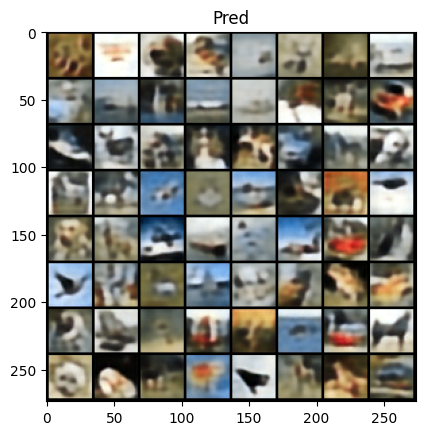

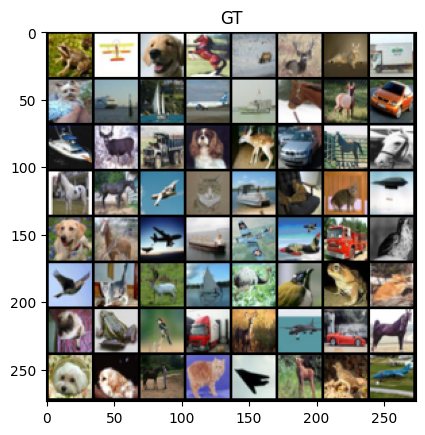

In [103]:
outputs = outputs.view(64, 3, 32, 32)
imshow(make_grid(outputs.detach().cpu()),'Pred')
imshow(make_grid(data[0]),'GT')

training loss is : 0.02748751074075699
validation loss is : 0.005624124931637197
training loss is : 0.0011709125782363118
validation loss is : 0.0035722830973099915
training loss is : 0.0007167421944905073
validation loss is : 0.0024957551213447005
training loss is : 0.0005315586150391028
validation loss is : 0.0021370721195125954
training loss is : 0.00044188210100401195
validation loss is : 0.0016476132994284853
training loss is : 0.0003425736591452733
validation loss is : 0.001386162378184963
training loss is : 0.0003621730004670098
validation loss is : 0.0011969171901000664
training loss is : 0.000252422280900646
validation loss is : 0.0010789105668663978
training loss is : 0.0002218257452477701
validation loss is : 0.0009091391155379824
training loss is : 0.00021465784637257458
validation loss is : 0.0008473598150885664


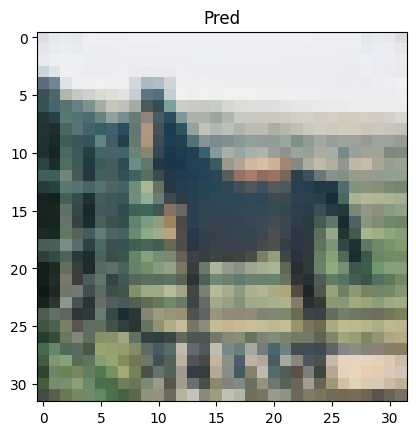

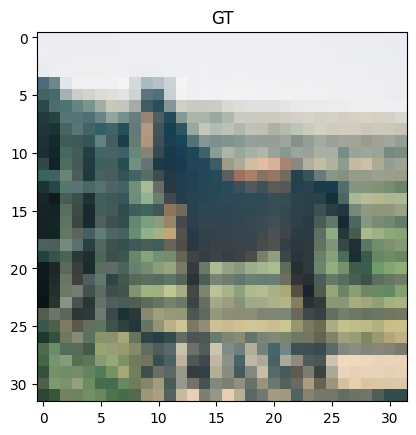

In [104]:
# TODO : Do all the things related to TRAINING here
# TODO : Change your model 
model = AutoEncoder_Conv(3,128)

# TODO : Reload your HyperParameters


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = model.to(device)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

# TODO : Rewrite your Training  and Validation Loop
for epoch in range(num_epochs) : 
    running_loss_t,running_loss_v = 0.0, 0.0
    for i, data in enumerate(train_loaderRGB, 0):
      image, label = data[0].to(device), data[1]
      optimizer.zero_grad()
      outputs = net(image)
      outputs = outputs.view(outputs.size(),-1).to(device)
      
      loss = criterion(outputs,image)
      loss.backward()
      optimizer.step()
      running_loss_t += loss.item()
      if i == 50:
        running_loss_t= running_loss_t/50
        print('training loss is :',running_loss_t)

    with torch.no_grad():
      
      for i, data in enumerate(val_loaderRGB, 0):
        image, label = data[0].to(device), data[1]
        outputs = net(image)
        outputs = outputs.view(outputs.size(),-1).to(device)
        loss = criterion(outputs,image )
        running_loss_v += loss.item()
        if i == 50:
            running_loss_v= running_loss_v/mini_batches_print 
            print('validation loss is :',running_loss_v)




# TODO : Rewrite your Testing Loop
with torch.no_grad():
  running_loss = []
  for i, data in enumerate(test_loaderRGB, 0):  
    image, label = data[0].to(device), data[1]
    outputs = net(image)
    outputs = outputs.view(outputs.size(),-1).to(device)
    loss = criterion(outputs,image )
    running_loss.append(loss)



imshow(outputs[22].detach().cpu(),'Pred')
imshow(data[0][22],'GT')

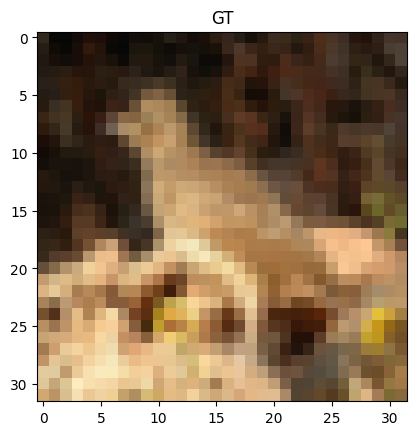

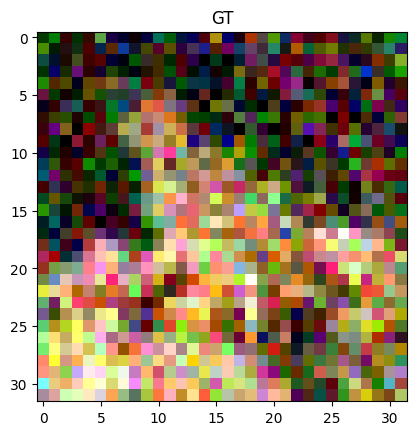

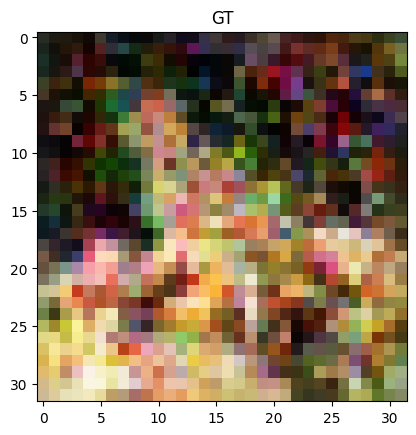

In [114]:
def add_noise(inputs, noise_factor):
     # Generate noise
     noise = torch.randn_like(inputs)
     # Add noise to the input
     noisy_inputs = inputs + noise_factor * noise
     return noisy_inputs



# TODO : Pick an image from the test set and add noise to it 
test_image = data[0][62] # Pick an image from test dataset
test_image = add_noise(test_image,0.2) # Add noise

# TODO : Send the Image through your model and plot the original image and the infered image
denoised_image = model(test_image.to(device))
imshow(data[0][62])
imshow(test_image)
imshow(denoised_image.detach().cpu())


Don't forget to write your results and explanation in your report

# 7 - Results

Now analyze your results and write your report.

